<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_12_6_Instinctual_DQN_GYMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot --quiet
!pip install deap --quiet

     |████████████████████████████████| 793 kB 3.1 MB/s 
     |████████████████████████████████| 381 kB 21.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.30 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.
     |████████████████████████████████| 160 kB 8.5 MB/s 


In [2]:
!apt-get install -y xvfb x11-utils
# install required python dependencies
!pip install gym[box2d]==0.17.* \
            pyvirtualdisplay==0.2.* \
            PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.* \
            mediapy \
            piglet -q

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.11 [785 kB]
Fetched 994 kB in 1s (1,368 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155653 fil

In [3]:
!echo $DISPLAY

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [5]:
import gym.wrappers
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
import mediapy 
import random
from collections import deque
from livelossplot import PlotLosses

import array

#DEAP
from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

action space: Discrete(4)
observation space: Box(-inf, inf, (8,), float32)


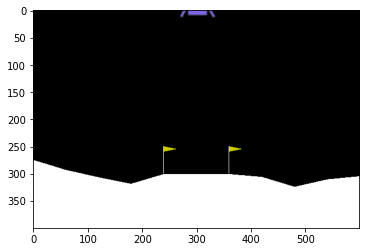

In [7]:
#@title Setup Environment { run: "auto" }
ENVIRONMENT = "LunarLander-v2" #@param ["CartPole-v1", "Acrobot-v1", "CubeCrash-v0", "MountainCar-v0", "LunarLander-v2"]

env = gym.make(ENVIRONMENT)

state = env.reset()
plt.imshow(env.render(mode='rgb_array'))

print("action space: {0!r}".format(env.action_space))
print("observation space: {0!r}".format(env.observation_space))

In [7]:
#@title Siumlate Environment Run { run: "auto" }
ENVIRONMENT = "CartPole-v1" #@param ["CartPole-v1", "Acrobot-v1", "MountainCar-v0", "LunarLander-v2"]
SIMULATION_RUNS = 10 #@param {type:"slider", min:1, max:10, step:1}
SIMULATION_ITERATIONS = 200 #@param {type:"slider", min:50, max:200, step:1}

env = gym.make(ENVIRONMENT)

fitnesses = []
frames = []

for run in range(SIMULATION_RUNS):  
  state = env.reset()
  fitness = 0
  for i in range(SIMULATION_ITERATIONS):
    action = env.action_space.sample()
    state, reward, done, info = env.step(np.argmax(action))  
    frames.append(env.render(mode='rgb_array'))  
    fitness += reward       
    if done: 
      fitnesses.append(fitness) 
      break 

mediapy.show_video(frames, fps=30)
print(fitnesses)

[10.0, 10.0, 10.0, 9.0, 9.0, 10.0, 9.0, 9.0, 10.0, 9.0]


In [62]:
import tensorflow.keras as k
import tensorflow.keras.layers as kl

class DQNAgent():
    def __init__(self, instincts, state_size, action_size, memory):        
        self.state_size         = state_size
        self.action_size        = action_size
        self.memory             = memory
        self.learning_rate      = 0.001
        self.gamma              = 0.95              
        self.brain              = self._build_model(instincts)

    def _build_model(self, instincts):
        # Neural Net for Deep-Q learning Model 
        inputs = k.Input(shape=(self.state_size,))
        dense_in = instincts[0]
        dense1 = instincts[1]
        dense2 = instincts[2]
        dense3 = instincts[3]
        dense_out = instincts[4] # kl.Dense(self.action_size, activation='linear')

        x = dense_in(inputs)
        x1 = dense1(x)
        x2 = dense2(x)
        x3 = dense3(x)
        x = kl.concatenate([x1, x2, x3])
        outputs = dense_out(x)
        model = k.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=k.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def save_model(self):
            self.brain.save(self.weight_backup)
            
    def mem_usage(self):
            return len(self.memory)/2000

    def act(self, state): 
        #no need for random search anymore       
        #if np.random.rand() <= .3:
            #return random.randrange(self.action_size)
        act_values = self.brain.predict(state)        
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))    

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return        
        sample_batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in sample_batch:
            target = reward
            if not done:
              target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0])
            target_f = self.brain.predict(state)
            target_f[0][action] = target
            self.brain.fit(state, target_f, epochs=1, verbose=0)
        

In [63]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print(state_size, action_size)

8 4


In [64]:
input_layers = [
          kl.Dense(24, activation="relu"),
          kl.Dense(24, activation="relu"),
          kl.Dense(24, activation="relu"),          
]

middle_layers = [
          kl.Dense(8, activation="relu"),
          kl.Dense(8, activation="relu"),
          kl.Dense(8, activation="relu"),               
]

output_layers = [
          kl.Dense(action_size, activation="linear"),
          kl.Dense(action_size, activation="linear"),
          kl.Dense(action_size, activation="linear"),          
]

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
memory = deque(maxlen=2000)

instincts = [
             random.choice(input_layers),
             random.choice(middle_layers), 
             random.choice(middle_layers),
             random.choice(middle_layers),
             random.choice(output_layers)
             ]
agent = DQNAgent(instincts, state_size, action_size, memory)

In [65]:
done = False

for i in range(5):
  rewards = 0
  instincts = [random.choice(input_layers),
               random.choice(middle_layers),
               random.choice(middle_layers),
               random.choice(middle_layers),
               random.choice(output_layers)
               ]
  agent = DQNAgent(instincts, state_size, action_size, memory)  
  state = env.reset()
  state = np.reshape(state, [1, state_size])
  done=False
  while not done:    
    action = agent.act(state)   
    next_state, reward, done, _ = env.step(action) 
    rewards += reward   
    next_state = np.reshape(next_state, [1, state_size])
    agent.remember(state, action, reward, next_state, done)
    state = next_state 
  agent.replay(32)    
  print(rewards)

-114.60003355548169
-523.1273890915277
-129.35058013052787
-2556.198132513828
-703.3459464809407


In [66]:
frames = []
state = env.reset()
done = False
while not done:  
  state = np.reshape(state, [1, state_size])
  action = agent.act(state)
  next_state, reward, done, _ = env.step(action)  
  state = next_state
  fitness += reward
  #frames.append(env.render(mode='rgb_array'))
env.close()

print(fitness)
#mediapy.show_video(frames, fps=30)

-1867.653082091376


In [68]:
#@title Create the Environments "CartPole-v1", "Acrobot-v1", "MountainCar-v0", "LunarLander-v2"
environments = [
                #gym.make("MountainCar-v0"),
                gym.make("CartPole-v1"),
                #gym.make("Acrobot-v1"),
                gym.make("LunarLander-v2"),
                ]
print(str(environments[0]))

<TimeLimit<CartPoleEnv<CartPole-v1>>>


In [69]:
#@title Simulate over all environments
middle_layers = [
          kl.Dense(8, activation="relu"),
          kl.Dense(8, activation="relu"),
          kl.Dense(8, activation="relu"), 
          kl.Dense(8, activation="relu"),
          kl.Dense(8, activation="relu"),
          kl.Dense(8, activation="relu"),                
]

input_layers = [kl.Dense(24, activation="relu") for e in environments]
output_layers = [kl.Dense(e.action_space.n, activation="linear") for e in environments]
memories = [ deque(maxlen=2000) for e in environments]            

for i in range(3):
  total = 0
  for i, env in enumerate(environments):
    rewards = 0
    instincts = [input_layers[i], 
                 random.choice(middle_layers),
                 random.choice(middle_layers),
                 random.choice(middle_layers),
                 output_layers[i],
                 ]
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(instincts, state_size, action_size, memories[i])  
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    done=False
    while not done:    
      action = agent.act(state)   
      next_state, reward, done, _ = env.step(action) 
      rewards += reward   
      next_state = np.reshape(next_state, [1, state_size])
      agent.remember(state, action, reward, next_state, done)
      state = next_state 
    agent.replay(32) 
    total += rewards   
  print(total/len(environments))

-372.00228252323103
-166.98226534651968
-1657.0538473574677


In [70]:
#@title Define the base gene sequence
ENVIRONMENTS = len(environments)

LAYERS = [
          kl.Dense(8, activation="relu"),
          kl.Dense(8, activation="relu"),
          kl.Dense(8, activation="relu"),
          kl.Dense(8, activation="relu"),                           
]

input_layers = [kl.Dense(24, activation="relu") for e in environments]
output_layers = [kl.Dense(e.action_space.n, activation="linear") for e in environments]
memories = [ deque(maxlen=2000) for e in environments] 

def create_offspring():
  individual = []
  for e in environments:
    individual.append(random.uniform(0., 1.))
    individual.append(random.uniform(0., 1.))
    individual.append(random.uniform(0., 1.))  
  return individual

individual = create_offspring()
print(individual)

[0.03845566253792376, 0.028797214902520074, 0.09473298188859736, 0.8399233710532628, 0.21627573356577445, 0.4192286655351187]


In [71]:
#@title Setting up the Creator
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [72]:
#@title Create Individual and Population
NDIM = len(LAYERS)

toolbox = base.Toolbox()
toolbox.register("network", create_offspring)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.network)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=1, indpb=1.0/NDIM)
toolbox.register("select", tools.selTournament, tournsize=3)

In [73]:
def clamp(minv, maxv, v):
  return min(max(v, minv), maxv)

def convert_layer(layer):
  return clamp(0, len(LAYERS)-1, int(layer * len(LAYERS)))

print(convert_layer(.1))
print(convert_layer(.3))
print(convert_layer(.5))
print(convert_layer(.7))
print(convert_layer(.9))

0
1
2
2
3


In [85]:
#@title Create and Register Evaluate Function
#environment_max_rewards = [-1000 for e in environments]
input_layers = [kl.Dense(24, activation="relu") for e in environments]
output_layers = [kl.Dense(e.action_space.n, activation="linear") for e in environments]
memories = [ deque(maxlen=20000) for e in environments]  

def evaluate(individual, train=False):  
  total = 0
  for i, env in enumerate(environments):   
    rewards = 0    
    layer1 = convert_layer(individual[i*3])
    layer2 = convert_layer(individual[i*3+1])    
    layer3 = convert_layer(individual[i*3+2])  

    instincts = [input_layers[i],
                 LAYERS[layer1],
                 LAYERS[layer2],
                 LAYERS[layer3],
                 output_layers[i],
                 ]
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(instincts, state_size, action_size, memories[i])  
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    done=False
    while not done:    
      action = agent.act(state)   
      next_state, reward, done, _ = env.step(action) 
      rewards += reward   
      next_state = np.reshape(next_state, [1, state_size])
      agent.remember(state, action, reward, next_state, done)
      state = next_state    
    total += rewards 
    if train:
      #only train if the agent is the best      
      agent.replay(32)
    
  print(total/len(environments))
  return total/len(environments),

toolbox.register("evaluate", evaluate)   

In [87]:
#@title Setup Evolution
MU = 5 #@param {type:"slider", min:5, max:1000, step:5}
NGEN = 1000 #@param {type:"slider", min:5, max:1000, step:1}
RGEN = 1 #@param {type:"slider", min:1, max:100, step:1}
CXPB = .6
MUTPB = .3

random.seed(64)

pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

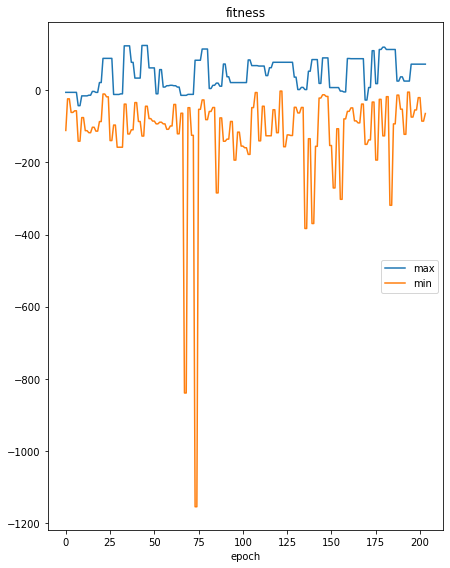

fitness
	max              	 (min:  -42.364, max:  124.727, cur:   72.857)
	min              	 (min: -1155.257, max:   -1.862, cur:  -64.080)
Gen (102) Best Fitness ((-57.133287809951526,))
-50.358696611826126
108.80536639192476


In [ ]:
best = None
groups = { "fitness" : {"min", "max"}}
plotlosses = PlotLosses(groups=groups)

for g in range(NGEN):
  pop, logbook = algorithms.eaSimple(pop, toolbox, 
            cxpb=CXPB, mutpb=MUTPB, ngen=RGEN, stats=stats, halloffame=hof, verbose=False)
  best = hof[0] 
  best_fit = evaluate(best, train=True) 
        
  for l in logbook:
    plotlosses.update({'max': l["max"], 'min': l["min"]})    
  plotlosses.send()  # draw, update logs, etc
  print(f"Gen ({(g+1)*RGEN}) Best Fitness ({best_fit})")

In [ ]:
fitness = 0
frames = []

state = env.reset()
done = False
while not done:  
  state = np.reshape(state, [1, state_size])
  action = agent.act(state)
  next_state, reward, done, _ = env.step(action)  
  state = next_state
  fitness += reward
  frames.append(env.render(mode='rgb_array'))
env.close()

print(fitness)
mediapy.show_video(frames, fps=30)